### AM2.5 control vs. KillTC comparison

#### Imports

In [2]:
# import cftime
import datetime
import numpy as np
import os
import pandas as pd
import random
import scipy
import xarray as xr

import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#### Reference values

In [3]:
dirs = {'AM2.5_ctrl': '/tigress/wenchang/MODEL_OUT/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/POSTP/',
        'AM2.5_ktc2': '/tigress/wenchang/MODEL_OUT/AM2.5ktc/CTL1990s_killtc12_tigercpu_intelmpi_18_540PE/POSTP/',
        'AM2.5_tc_ctrl': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/netcdf/',
        'AM2.5_tc_ktc2': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/netcdf/'}

In [2]:
dirs = {'AM2.5_tc_ctrl': '/tigress/wenchang/analysis/TC/AM2.5/CTL1990s_tigercpu_intelmpi_18_540PE/model_out/POSTP',
        'AM2.5_tc_ktc2': '/tigress/wenchang/analysis/TC/AM2.5ktc2/CTL1990s_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP',
        'HIRAM_tc_ctrl': '/tigress/wenchang/analysis/TC/HIRAM/CTL1990s_v201910_tigercpu_intelmpi_18_540PE/model_out/POSTP',
        'HIRAM_tc_ktc2': '/tigress/wenchang/analysis/TC/HIRAMktc2/CTL1990s_v201910_killtc13-13-15_tigercpu_intelmpi_18_540PE/modelout/POSTP'}

#### Script parameters

In [75]:
experiment_names = ['AM2.5_tc_ctrl', 'AM2.5_tc_ktc2']
output_type = 'atmos_month'

In [5]:
tc_experiment_names = ['AM2.5_tc_ctrl', 'AM2.5_tc_ktc2']
tc_output_type = 'tc_counts'

#### Non-TC specific processing

In [77]:
indices = random.sample(range(1, 100), 10)
datasets = {experiment_names[0]: pull(experiment_names[0], output_type, mode='all', indices=None),
            experiment_names[1]: pull(experiment_names[1], output_type, mode='all', indices=None)}

In [119]:
datasets[experiment_names[0]]['temp']

<xarray.DataArray 'temp' (time: 600, pfull: 32, grid_yt: 360, grid_xt: 576)>
dask.array<concatenate, shape=(600, 32, 360, 576), dtype=float32, chunksize=(12, 32, 360, 576), chunktype=numpy.ndarray>
Coordinates:
  * grid_xt  (grid_xt) float64 0.3125 0.9375 1.562 2.188 ... 358.4 359.1 359.7
  * grid_yt  (grid_yt) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * pfull    (pfull) float64 2.164 5.845 10.75 17.11 ... 963.7 976.7 987.4 996.1
  * time     (time) object 0101-01-16 12:00:00 ... 0150-12-16 12:00:00
Attributes:
    long_name:      temperature
    units:          K
    valid_range:    [100. 350.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    interp_method:  conserve_order1

Check for model spinup to ensure proper time sampling for analysis

AM2.5 KillTC - AM2.5 control

Text(0.5, 1.0, 'AM2.5_ktc2, atmos_month\n101-150')

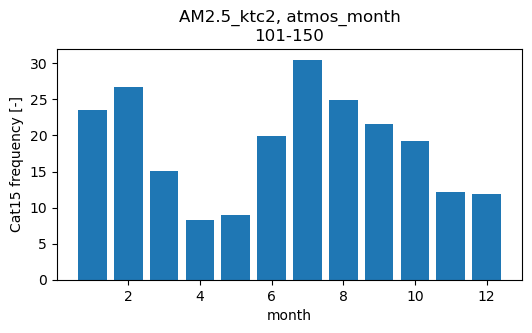

In [66]:
# Bar plot of frequency, globally
var = 'f15'
experiment_name = experiment_names[1]
dataset = datasets[experiment_name]

plot_data = dataset[var].groupby('time.month').mean().sum(dim=['grid_xt', 'grid_yt'])
x, y = [plot_data.month, plot_data]

# plot_data = (datasets[experiment_names[1]] - datasets[experiment_names[0]])[var].groupby('time.month').mean().sum(dim=['grid_xt', 'grid_yt'])
# x, y = [plot_data.month, 
#         100*plot_data.values/datasets[experiment_names[0]].groupby('time.month').mean().sum(dim=['grid_xt', 'grid_yt'])[var].values]


fig, ax = plt.subplots(figsize=(6, 3))
im = ax.bar(x, y)

try:
    units = '-' if dataset[var].attrs['units'] == 'none' else dataset[var].attrs['units']
except:
    units = '-'
    
title = '{0}, {1}\n{2}-{3}'.format(experiment_name, output_type, 
                                   min(sorted(set(dataset.time.dt.year.values))), 
                                   max(sorted(set(dataset.time.dt.year.values))))

ax.set_xlabel('month')
try:
    ax.set_ylabel('{0} [{1}]'.format(dataset[var].attrs['long_name'], units))
except:
    ax.set_ylabel('{0} [{1}]'.format('Category 1-5 frequency', units))
    
ax.set_title(title)

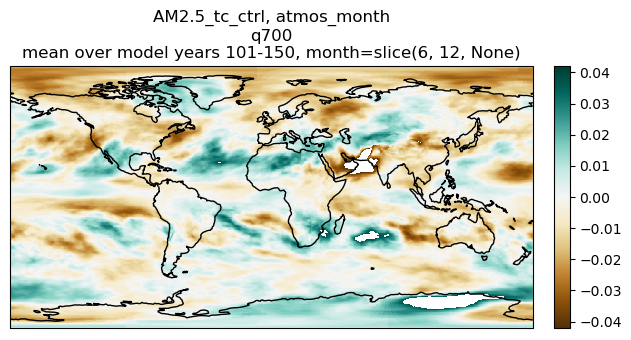

In [114]:
extent = [-180, 180, -90, 90]

var = 'q700'
experiment_name = experiment_names[0]
dataset = datasets[experiment_names[1]] - datasets[experiment_names[0]]
plot_data = dataset[var].groupby('time.month').mean()

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# norm = matplotlib.colors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
norm = matplotlib.colors.CenteredNorm(vcenter=0)
cmap = 'BrBG' if var in ['WVP', 'precip', 'q200', 'q700'] else 'RdBu_r'
# im = ax.pcolormesh(plot_data.grid_xt, plot_data.grid_yt, 
#                    100*plot_data.isel(month=month).mean('month')/datasets[experiment_names[0]][var].groupby('time.month').mean().isel(month=month).mean('month'), 
#                    norm=norm, cmap=cmap, transform=ccrs.PlateCarree())

values = dataset[var].groupby('time.year').mean().mean('year')/datasets[experiment_names[0]][var].groupby('time.year').mean().mean('year')
values = values.where((values > values.mean() - 3*values.std()) & (values < values.mean() + 3*values.std()))

im = ax.pcolormesh(dataset.grid_xt, dataset.grid_yt, 
                   values, 
                   norm=norm, cmap=cmap, transform=ccrs.PlateCarree())


ax.coastlines()
ax.set_extent(extent)
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])

cax = ax.inset_axes([1.04, 0, 0.03, 1])
colorbar = fig.colorbar(im, ax=ax, cax=cax)

# units = '-' if dataset[var].attrs['units'] == 'none' else dataset[var].attrs['units']
title = '{0}, {1}\n{2}\nmean over model years {3}-{4}, month={5}'.format(experiment_name, output_type, var,
                                                                    min(sorted(set(datasets[experiment_names[0]].time.dt.year.values))), 
                                                                    max(sorted(set(datasets[experiment_names[0]].time.dt.year.values))),
                                                                    month)

ax.set_title(title)
# colorbar.set_label(units, rotation=270, labelpad=20)

fig.tight_layout()

#### Processing for TC-specific data

In [18]:
tc_experiment_names = ['AM2.5_tc_ctrl', 'AM2.5_tc_ktc2']
tc_output_type = 'tc_counts'

In [28]:
tc_datasets = {tc_experiment_names[0]: pull(tc_experiment_names[0], tc_output_type),
               tc_experiment_names[1]: pull(tc_experiment_names[1], tc_output_type)}

Compare AM2.5 control and KillTC experiments

<Axes: xlabel='month'>

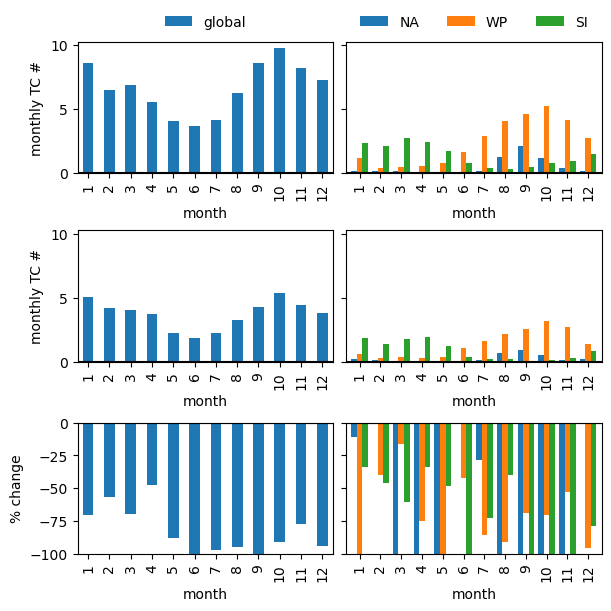

In [32]:
data_ctrl, data_ktc = tc_datasets['AM2.5_tc_ctrl'], tc_datasets['AM2.5_tc_ktc2']
comp = tc_datasets['AM2.5_tc_ktc2'] - tc_datasets['AM2.5_tc_ctrl']

print(data_ctrl.time == )

basins = ['NA', 'WP', 'SI']

widths = [1, 1]
heights = [1, 1, 1]
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)

###

ctrl_mean_global, ctrl_std_global = [data_ctrl.groupby('time.month').mean().to_dataframe()['global'], 
                                     data_ctrl.groupby('time.month').std().to_dataframe()['global']]
ctrl_mean, ctrl_std = [data_ctrl.groupby('time.month').mean().to_dataframe()[basins], 
                       data_ctrl.groupby('time.month').std().to_dataframe()[basins]]

ax_tl = fig.add_subplot(gs[0, 0])
ctrl_mean_global.plot.bar(ax=ax_tl, width=0.5,)
ax_tl.hlines(xmin=-1, xmax=ctrl_mean_global.index.max(), y=0, colors='k')
ax_tl.set_ylabel('monthly TC #')
ax_tl.legend(frameon=False, bbox_to_anchor=(0.5, 1.15), loc='center')

###

ax_tr = fig.add_subplot(gs[0, 1], sharey=ax_tl)
ctrl_mean.plot.bar(ax=ax_tr, width=0.8, legend=False)
ax_tr.hlines(xmin=-1, xmax=ctrl_mean.index.max(), y=0, colors='k')
ax_tr.set_ylim()
ax_tr.legend(frameon=False, bbox_to_anchor=(0.5, 1.15), ncols=3, loc='center')

###

ktc_mean_global, ktc_std_global = [data_ktc.groupby('time.month').mean().to_dataframe()['global'], 
                                   data_ktc.groupby('time.month').std().to_dataframe()['global']]
ktc_mean, ktc_std = [data_ktc.groupby('time.month').mean().to_dataframe()[basins], 
                     data_ktc.groupby('time.month').std().to_dataframe()[basins]]

ax_cl = fig.add_subplot(gs[1, 0], sharey=ax_tl)
ktc_mean_global.plot.bar(ax=ax_cl, width=0.5,)
ax_cl.hlines(xmin=-1, xmax=ktc_mean_global.index.max(), y=0, colors='k')
ax_cl.set_ylabel('monthly TC #')

###

ax_cr = fig.add_subplot(gs[1, 1], sharey=ax_tl)
ktc_mean.plot.bar(ax=ax_cr, width=0.8, legend=False)
ax_cr.hlines(xmin=-1, xmax=ktc_mean.index.max(), y=0, colors='k')
###

comp_mean_global, comp_std_global = [100*comp.groupby('time.month').mean().to_dataframe()['global']/ktc_mean_global, 
                                     comp.groupby('time.month').std().to_dataframe()['global']]
comp_mean, comp_std = [100*comp.groupby('time.month').mean().to_dataframe()[basins]/ktc_mean, 
                       comp.groupby('time.month').std().to_dataframe()[basins]]

# Left bottom axis
ax_bl = fig.add_subplot(gs[2, 0])
ax_bl.hlines(xmin=-1, xmax=comp_mean_global.index.max(), y=0, colors='k')
comp_mean_global.plot.bar(ax=ax_bl, width=0.5,)
# mean.plot.bar(ax=ax, width=0.7, yerr=std, error_kw=dict(capsize=3, capthick=1, lw=1, ecolor='gray'))
ax_bl.set_ylabel('% change')
ax_bl.set_ylim([-100, 0])

# Right bottom axis
ax_br = fig.add_subplot(gs[2, 1], sharey=ax_bl)
ax_br.hlines(xmin=-1, xmax=comp_mean.index.max(), y=0, colors='k')
comp_mean.plot.bar(ax=ax_br, width=0.8, legend=False)
# mean.plot.bar(ax=ax, width=0.7, yerr=std, error_kw=dict(capsize=3, capthick=1, lw=1, ecolor='gray'))

#### Energy spectra

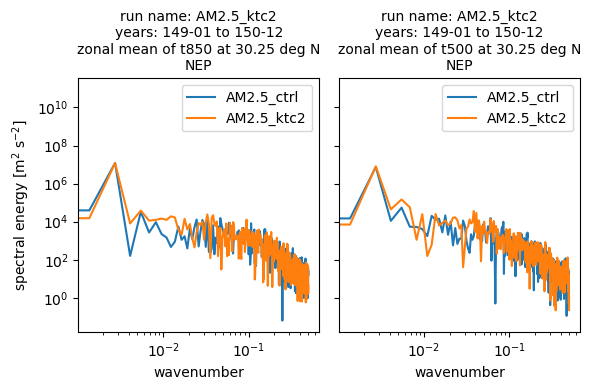

In [144]:
experiment_names = ['AM2.5_ctrl', 'AM2.5_ktc2']
# Get kinetic energy for 850 hPa
datasets = {experiment: ke(dataset, level=850) for experiment, dataset in datasets.items()}
# Get kinetic energy for 250 hPa
datasets = {experiment: ke(dataset, level=250) for experiment, dataset in datasets.items()}
energy_spectra(experiment_names, params=['t850', 't500'], basin='NEP')

In [140]:
def energy_spectra(experiment_names, params=['u850', 'u200'], lat=30.25, basin='global'):
    
    basin_lons = {'NEP': slice(110, 260),
                  'NA': slice(300, 350),
                  'global': slice(0, 360)}
    
    spectra = {}
    
    for param in params:
        spectra[param] = {}
        for experiment in experiment_names:
            zonal_mean = datasets[experiment][param].sel(grid_xt=basin_lons[basin], grid_yt=lat).mean('grid_xt')

            N = len(zonal_mean.time)
            k_freq = scipy.fft.fftfreq(N, 1)[:N//2]
            zonal_mean_k = scipy.fft.fft(zonal_mean.values)[:N//2]
            energy = 2*(np.real(zonal_mean_k)**2 + np.imag(zonal_mean_k)**2)
            
            spectra[param][experiment] = {'lat': lat,
                                          'freq': k_freq, 
                                          'time': zonal_mean.time,
                                          'spectral_energy': energy}
            
    ncols = len(params)
    fig, axs = plt.subplots(figsize=(3*ncols, 4), ncols=ncols, sharex=True, sharey=True)
    
    for i, ax in enumerate(axs):
        param = params[i]
        ax_spectra = spectra[param]
        for experiment, experiment_data in ax_spectra.items():
            ax.plot(experiment_data['freq'], experiment_data['spectral_energy'], label=experiment)
            ax.set_xscale('log')
            ax.set_yscale('log')

            ax_title = 'run name: {0}\nyears: {1:02d}-{2:02d} to {3:02d}-{4:02d}\nzonal mean of {5} at {6:.2f} deg N\n{7}'.format(experiment, 
                                                                                                               experiment_data['time'].values[0].year,
                                                                                                               experiment_data['time'].values[0].month,
                                                                                                               experiment_data['time'].values[-1].year,
                                                                                                               experiment_data['time'].values[-1].month,
                                                                                                               param, lat, basin)
        ax.set_title(ax_title, fontsize=10)
        if i == 0:
            ax.set_ylabel('spectral energy [m$^{2}$ s$^{-2}$]')
        ax.set_xlabel('wavenumber')
        ax.legend(loc='upper right')
        
    fig.tight_layout()

#### Methods

In [76]:
def pull(experiment, output_type, mode='tc', indices=None):
    ''' Method to read data for given parameters. '''
    
    # Retrieve directory name for corresponding model and experiment
    dirname = dirs[experiment]
    # Get filenames for corresponding files (0 index used for test runs)
    if mode == 'tc':
        fname = sorted([os.path.join(dirname, file) for file in os.listdir(dirname) 
                        if (output_type == file.split('.')[0]) and ('.nc' in file) 
                        and ('yearly' not in file) and ('all' not in file)])
    else:
        fname = sorted([os.path.join(dirname, file) for file in os.listdir(dirname) 
                            if (output_type == file.split('.')[1]) and ('.nc' in file)])[:50]
        #fname = fname[::5]
        if indices:
            fname = [fname[i] for i in indices]
    # Retrieve data
    data = xr.open_mfdataset(fname)
    
    return data

In [7]:
def cftime_parser(cfdate, input_type='index'):
    ''' 
    Converts CFTime date to datetime date for a single date (input_type = 'single') 
    or a Dataset/DataArray index (input_type = 'index', default).
    '''
    
    # Define date format
    fmt = '%Y-%m-%d'
    # Initialize empty list ot hold new dates
    dates = []
    # Handle each input type
    if input_type == 'index':
        # return [datetime.datetime(year=date.year, month=date.month, day=date.day, hour=date.hour)
        #         for date in cfdate]
        strs =  [datetime.datetime(year=date.year+1700, month=date.month, day=date.day, hour=date.hour).strftime(fmt)
                 for date in cfdate]
        print(strs)
        return np.array(strs, dtype='datetime64')
    elif input_type == 'single':
        return datetime.datetime(year=cfdate.year, month=cfdate.month, day=cfdate.day, hour=cfdate.hour)

In [121]:
def ke(data, level=850):
    '''
    Calculate kinetic energy at a given level (u**2 + v**2)/2
    '''
    
    data['e{0}'.format(level)] = (data['u{0}'.format(level)]**2 + data['v{0}'.format(level)]**2)/2
    
    return data